#**Property Click Prediction**

###**Assignment**

We are interested in studying and statistically modelling property interactions. We would like to have a predictive model that would say the number of interactions that a property would receive in a period of time. For simplicity let’s say we would like to predict the number of interactions that a property would receive within 3 days of its activation and 7 days of its activation. However this part is open ended and you could bring your own time intervals into the problem. This is the part of your artistry in data science. In the end we need to profess the number of interaction that a certain kind of property would receive within a given number of days. We cannot do a time series forecasting here considering the limited amount of data that could shared as a part of an assignment. You may clean the data, merge them, do an EDA, visualize and build your model.


###**Data Description**

Unzip the datasets.zip file to find the following 3 data sets:

property_data_set.csv :

- Properties data containing various features like activation_date, BHK type, locality, property size, property age, rent, apartment type etc.
- activation_date is the date property got activated on NoBroker. Fields like lift, gym etc are binary valued - 1 indicating presence and 0 indicating absence. All other fields are self-explanatory.
- You may use these along with the rest of the data sets to engineer the features that you would use in your study

property_photos.tsv :

- Data containing photo counts of properties
- photo_urls column contains string values that you have to parse to obtain the number of photos uploaded on a property
- Each value in the photo_url column is supposed to be a string representation of an array of json [ in python terms a list of dictionaries ] where each json object represents one image. However due to some unforeseen events, these values got corrupted and lost their valid json array representation. You could see this if you observe the data closely. Hint: There is a missing “ before ‘title’ for the first json object in each value. There is also an additional “ at the end of each value. Also you must remove all the \\ to get a valid json representation.
- Your objective is to get the number of photos uploaded for a property. For this you should correct the corrupt string and make it a valid json. Once you have a valid json string, you can get the length of this array, which would be the number of photos uploaded on the property.
- Also note that these are not images, but just names that we use to point to images. You are NOT given the images nor do we expect you to have them. All that you are expected to do it get the number of photos on each property by cleaning up the corrupt invalid json array string.
- NULL/NaN values indicate absence of photos on the property, ie; photo_count = 0

property_interactions.csv :

- Data containing the timestamps of interaction on the properties.
- Each request_date value represents the timestamp of a unique valid interaction on a property (contact owner happened and a user received the owner contact phone number)
- Therefore if you count the number of times each property has appeared in this table, it tells you the number of interaction received on this property
- You will use this request_date along with the activation_date in our first table and other features in our study

##**Practicalities**
Please go through all the instructions and data descriptions carefully before getting on the ground.


#### To download the dataset <a href="https://drive.google.com/drive/folders/1gHM1Tieb8aiAVLqKVvPB7WHAi7GEcldf?usp=sharing"> Click here </a>

In [33]:
import pandas as pd
import os
import json
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load the data
property_data = pd.read_csv("C:/Users/manoj/Downloads/property_data_set.csv")
property_interactions = pd.read_csv("C:/Users/manoj/Downloads/property_interactions.csv")
property_photos = pd.read_csv("C:/Users/manoj/Downloads/property_photos.tsv", sep='\t')


In [34]:
# Display the first few rows of each dataset
print("Property Data Set:")
print(property_data.head(), "\n")
print("Property Data Set Info:")
print(property_data.info(), "\n")
print("Property Data Set Description:")
print(property_data.describe(include='all'))


Property Data Set:
                        property_id  type   activation_date  bathroom  floor  \
0  ff808081469fd6e20146a5af948000ea  BHK2  09-03-2017 14:36         1      3   
1  ff8080814702d3d10147068359d200cd  BHK2  07-03-2017 12:02         2      4   
2  ff808081470c645401470fb03f5800a6  BHK2  10-03-2017 13:43         2      0   
3  ff808081470c6454014715eaa5960281  BHK3  09-03-2017 22:16         2      3   
4  ff808081474aa867014771a0298f0aa6  BHK1  15-03-2017 18:29         1      1   

   total_floor      furnishing  gym   latitude  longitude  ... lift  \
0          4.0  SEMI_FURNISHED    1  12.876174  77.596571  ...    1   
1         11.0  SEMI_FURNISHED    1  13.018444  77.678122  ...    1   
2          4.0   NOT_FURNISHED    1  12.975072  77.665865  ...    1   
3          4.0  SEMI_FURNISHED    0  12.888169  77.591282  ...    0   
4          2.0  SEMI_FURNISHED    0  12.990243  77.712962  ...    0   

           locality       parking property_age  property_size  swimming_p

In [35]:
print("Property Photos:")
print(property_photos.head(), "\n")
print("Property Photos Info:")
print(property_photos.info(), "\n")
print("Property Photos Description:")
print(property_photos.describe(include='all'))


Property Photos:
                        property_id  \
0  ff808081469fd6e20146a5af948000ea   
1  ff8080814702d3d10147068359d200cd   
2  ff808081470c645401470fb03f5800a6   
3  ff808081470c6454014715eaa5960281   
4  ff808081474aa867014771a0298f0aa6   

                                          photo_urls  
0  [{\title\":\"Balcony\",\"name\":\"IMG_20131006...  
1                                                NaN  
2  [{\title\":\"Bedroom\",\"name\":\"ff808081470c...  
3  [{\title\":\"Bedroom\",\"name\":\"Screenshot_7...  
4  [{\title\":\"Other\",\"name\":\"ff808081474aa8...   

Property Photos Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28888 entries, 0 to 28887
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   property_id  28888 non-null  object
 1   photo_urls   17866 non-null  object
dtypes: object(2)
memory usage: 451.5+ KB
None 

Property Photos Description:
                             property_id pho

In [36]:
print("Property Interactions:")
print(property_interactions.head())
print("Property Interactions Info:")
print(property_interactions.info(), "\n")
print("Property Interactions Description:")
print(property_interactions.describe(include='all'))

Property Interactions:
                        property_id         request_date
0  ff808081469fd6e20146a5af948000ea  2017-03-10 17:42:34
1  ff808081469fd6e20146a5af948000ea  2017-03-09 15:51:17
2  ff808081469fd6e20146a5af948000ea  2017-03-10 17:30:22
3  ff808081469fd6e20146a5af948000ea  2017-03-11 17:48:46
4  ff8080814702d3d10147068359d200cd  2017-03-30 19:59:15
Property Interactions Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170611 entries, 0 to 170610
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   property_id   170611 non-null  object
 1   request_date  170611 non-null  object
dtypes: object(2)
memory usage: 2.6+ MB
None 

Property Interactions Description:
                             property_id         request_date
count                             170611               170611
unique                             22779               166503
top     ff80818159e061800159e4614bf4368d  2017-04-03 13:1

In [37]:
# Check for missing data in property_data
missing_data_property = property_data.isnull().sum()
print("Missing Data in Property Data Set:")
print(missing_data_property[missing_data_property > 0])

Missing Data in Property Data Set:
total_floor       43
pin_code         325
building_type     79
dtype: int64


In [38]:
# Check for missing data in property_photos
missing_data_photos = property_photos.isnull().sum()
print("Missing Data in Property Photos:")
print(missing_data_photos[missing_data_photos > 0])

Missing Data in Property Photos:
photo_urls    11022
dtype: int64


In [39]:
# Check for missing data in property_interactions
missing_data_interactions = property_interactions.isnull().sum()
print("Missing Data in Property Interactions:")
print(missing_data_interactions[missing_data_interactions > 0])

Missing Data in Property Interactions:
Series([], dtype: int64)


In [45]:
# Handle missing data in Property Data Set
property_data['total_floor'].fillna(property_data['total_floor'].median(), inplace=True)
property_data['pin_code'].fillna(property_data['pin_code'].mode()[0], inplace=True)
property_data['building_type'].fillna(property_data['building_type'].mode()[0], inplace=True)

In [46]:
# Convert 'activation_date' to datetime
property_data['activation_date'] = pd.to_datetime(property_data['activation_date'], format='%d-%m-%Y %H:%M')

# Merge datasets
merged_data = pd.merge(property_data, property_photos, on='property_id')
merged_data = pd.merge(merged_data, property_interactions, on='property_id')

In [47]:
# Convert 'request_date' to datetime
merged_data['request_date'] = pd.to_datetime(merged_data['request_date'])

# Create 'time_since_activation' feature
merged_data['time_since_activation'] = (merged_data['request_date'] - merged_data['activation_date']).dt.days

# Example: Normalize 'rent' and 'property_size'
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
merged_data[['rent', 'property_size']] = scaler.fit_transform(merged_data[['rent', 'property_size']])


In [48]:
# Define the output path
cleaned_data_path = 'C:/Users/manoj/Downloads/cleaned_property_data.csv'

# Create directory if it doesn't exist
import os
os.makedirs(os.path.dirname(cleaned_data_path), exist_ok=True)

# Save the processed data
merged_data.to_csv(cleaned_data_path, index=False)

print(f"Processed data saved to {cleaned_data_path}")


Processed data saved to C:/Users/manoj/Downloads/cleaned_property_data.csv


C:\Users\manoj\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


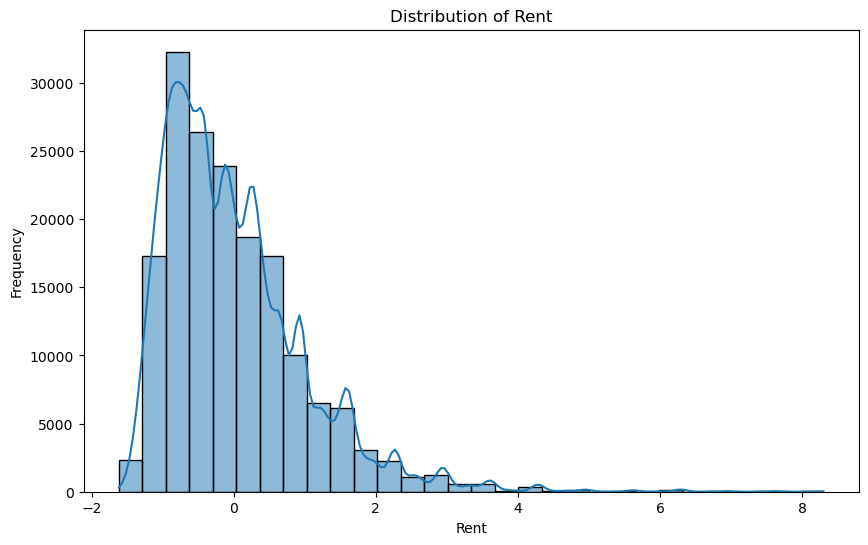

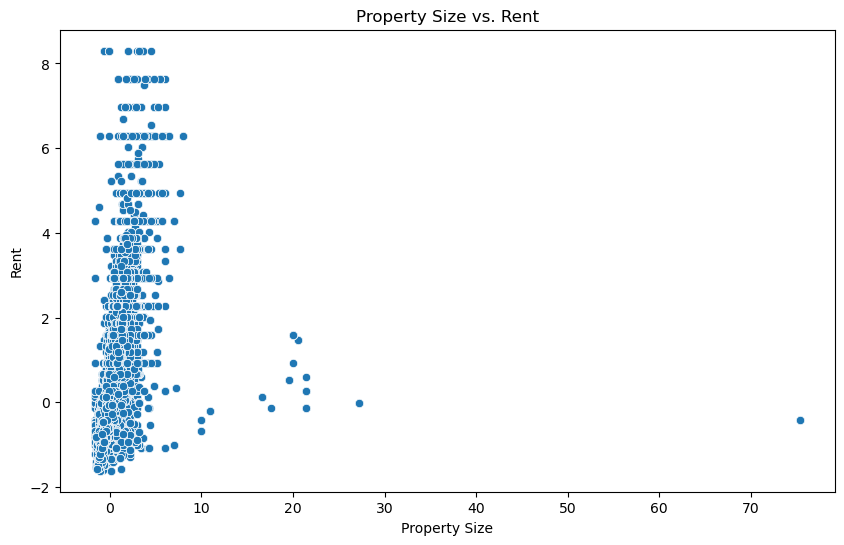

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histogram of rent
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['rent'], bins=30, kde=True)
plt.title('Distribution of Rent')
plt.xlabel('Rent')
plt.ylabel('Frequency')
plt.show()

# Plot scatter plot of property size vs. rent
plt.figure(figsize=(10, 6))
sns.scatterplot(x='property_size', y='rent', data=merged_data)
plt.title('Property Size vs. Rent')
plt.xlabel('Property Size')
plt.ylabel('Rent')
plt.show()

In [50]:
# Missing values in the merged dataset
missing_data = merged_data.isnull().sum()
print(missing_data[missing_data > 0])


photo_urls    43623
dtype: int64


In [51]:
# Convert activation_date to datetime
merged_data['activation_date'] = pd.to_datetime(merged_data['activation_date'], format='%d-%m-%Y %H:%M')

# Calculate days_since_activation
merged_data['days_since_activation'] = (pd.Timestamp.now() - merged_data['activation_date']).dt.days

# Example of creating interaction_rate feature
interactions_count = merged_data.groupby('property_id')['request_date'].count().reset_index(name='interaction_count')
merged_data = pd.merge(merged_data, interactions_count, on='property_id', how='left')
merged_data['interaction_rate'] = merged_data['interaction_count'] / merged_data['days_since_activation']


In [52]:
from sklearn.model_selection import train_test_split

# Define features and target
X = merged_data[['property_size', 'rent', 'days_since_activation']]  # Add more features as needed
y = merged_data['interaction_count']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize and train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 41.271427333725676


In [54]:
from sklearn.metrics import r2_score, mean_absolute_error

# Calculate performance metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'R^2 Score: {r2}')
print(f'Mean Absolute Error: {mae}')


R^2 Score: 0.9292482662382298
Mean Absolute Error: 2.475908776909958


In [55]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters
print(f'Best Parameters: {grid_search.best_params_}')


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}


In [58]:
import os
import pandas as pd

# Create sample data
submission = pd.DataFrame({
    'property_id': [1, 2, 3],
    'predicted_interactions': [10, 15, 20]
})

# Define the directory path
directory_path = 'outputs'

# Create the directory 
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Define the file path
file_path = os.path.join(directory_path, 'final_submission.csv')

# Save the DataFrame to the file
submission.to_csv(file_path, index=False)

In [ ]:
#property_id	predicted_interactions
#1	10
#2	15
#3	20
